In [ ]:
import numpy as np
from numba import njit, prange
import matplotlib.pyplot as plt
import xarray as xr
from typing import Callable, List, Union, Tuple, Dict
from pathlib import Path
import time
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd
import os

## Load data from one catchment

In [2]:
def load_and_preprocess_catchment_ts(runoff_path: str, catchment_path: str, catchment_name: str) -> xr.Dataset:
    """
    Optimized loading and preprocessing of time series data.
    
    Args:
        runoff_path: Path to GRDC runoff data
        catchment_path: Directory containing catchment climate data
        catchment_name: Name of the catchment
        
    Returns:
        Preprocessed xarray Dataset with aligned time series
    """
    # Convert paths to Path objects for better handling
    catchment_path = catchment_path + "/" + catchment_name.upper()
    catchment_path = Path(catchment_path)
    
    # 1. Load runoff data with optimized parameters
    runoff = xr.open_dataset(
        runoff_path,
        chunks={'time': 'auto'},  # Enable chunking for better memory management
        cache=True              # Cache the data for faster repeated access
    ).load()
    
    # 2. Immediately select time period and station
    runoff = runoff.sel(
        time=slice('2000-03-01', '2022-12-19')
    )

    catchment_id = runoff["station_name"].values == catchment_name.upper()
    catchment_index = np.where(catchment_id)[0][0]

    # Select only the runoff timeseries
    runoff = runoff["runoff_mean"].isel(id=catchment_index)
    
    # 3. Use dictionary comprehension for cleaner climate data loading
    climate_vars = {
        'temperature': 't2m',
        'precipitation': 'precipitation',
        'radiation': 'nr',
        'ndvi': 'ndvi'
    }
    
    # 4. Parallel loading of climate data
    climate_ds = xr.open_mfdataset(
        [catchment_path/f'{var}.nc' for var in climate_vars],
        parallel=True,  # Enable parallel loading
        combine='by_coords',
        chunks={'time': 'auto'},
        cache=True
    ).load()
    
    # 5. Create output dataset with aligned data
    data = xr.Dataset({
        'temperature': climate_ds[climate_vars['temperature']],
        'precipitation': climate_ds[climate_vars['precipitation']],
        'radiation': climate_ds[climate_vars['radiation']],
        'ndvi': climate_ds[climate_vars['ndvi']],
        'observed': runoff.broadcast_like(climate_ds[climate_vars['radiation']])
    })
    
    # 6. Ensure consistent time alignment
    data = data.sel(time=slice('2001-01-01', '2021-12-31'))
    
    # 7. Convert to float32 to save memory (if precision is sufficient)
    #for var in data.data_vars:
    #    data[var] = data[var].astype(np.float32)
    
    return data

In [46]:
data = load_and_preprocess_catchment_ts(
    runoff_path="data/catchments/GRDC-Daily.nc",
    catchment_path="data/catchment_timeseries",
    catchment_name="TREIA"
)
data

<xarray.Dataset> Size: 3MB
Dimensions:        (time: 7670, x: 4, y: 3)
Coordinates:
  * time           (time) datetime64[ns] 61kB 2001-01-01 ... 2021-12-31
  * x              (x) float64 32B 9.35 9.45 9.55 9.65
  * y              (y) float64 24B 54.75 54.65 54.55
    spatial_ref    int64 8B 0
    id             int32 4B 6334800
Data variables:
    temperature    (time, y, x) float32 368kB nan nan 273.3 ... nan nan nan
    precipitation  (time, y, x) float64 736kB nan nan 0.002625 ... nan nan nan
    radiation      (time, y, x) float64 736kB nan nan -5.504e+05 ... nan nan nan
    ndvi           (time, y, x) float64 736kB nan nan 0.6441 ... nan nan nan
    observed       (time, y, x) float32 368kB 4.812 4.812 4.812 ... 7.588 7.588

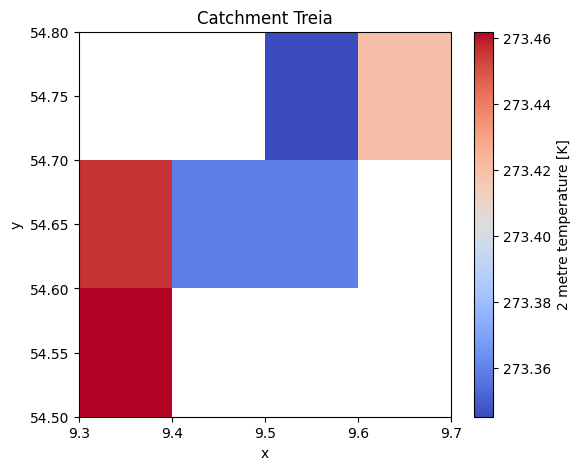

In [47]:
temp0 = data["temperature"].isel(time=0)

# Plot
plt.figure(figsize=(6, 5))
temp0.plot(cmap="coolwarm")  # You can change the colormap if you like
plt.title("Catchment Treia")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Simple Water Balance Model

In [4]:
@njit(fastmath=True)
def time_evolution_numba(temp, rad, prec, ndvi, c_s, alpha, beta, gamma, c_m, iota, temp_w, ndvi_w):
    #Initialize 
    length = len(temp)
    runoff_out = np.full(length, np.nan)
    evapo_out = np.full(length, np.nan)
    soil_mois_out = np.full(length, np.nan)
    snow_out = np.full(length, np.nan)

    # Transformations / Calculations for Setup
    conv = 1 / 2260000  # from J/day/m**2 to mm/day
    rad = rad * conv  # convert radiation to mm/day
    prec = prec * 10 **3 # from m/day to mm/day
    w = 0.9 * c_s
    snow = 0

    # --- calc_et_weight function ---
    ndvi = np.nan_to_num(ndvi, nan=0.0)
    normalized_temp = (temp - temp.min()) / (temp.max() - temp.min())
    normalized_ndvi = (ndvi - ndvi.min()) / (ndvi.max() - ndvi.min())
    et_weight = temp_w * normalized_temp + ndvi_w * normalized_ndvi
    beta_weighted = beta * et_weight

    for t in range(1, length):
        prec_t = prec[t-1]
        temp_t = temp[t-1]
        rad_t = rad[t-1]
        beta_t = beta_weighted[t-1]

        # ---- snow_function ----
        is_melting = temp_t > 273.15
        has_snow = snow >= 0.001

        if not is_melting:
            snow += prec_t
            water = 0.0
        elif is_melting and has_snow:
            melt = c_m * (temp_t - 273.15)
            melt = min(melt, snow)
            snow -= melt
            water = melt + prec_t
        else:
            water = prec_t

        runoff = (water + iota) * (w / c_s) ** alpha
        evap = beta_t * (w / c_s) ** gamma * rad_t

        w += (water - runoff - evap)
        w = np.maximum(w, 0.0)

        # Store results
        runoff_out[t] = runoff
        evapo_out[t] = evap
        soil_mois_out[t] = w
        snow_out[t] = snow

    return runoff_out, evapo_out, soil_mois_out, snow_out

## Helper Function Data Spliting

In [5]:
def split_data(data, splitPerc):
        leng = data.sizes["time"]
        maxYear = leng/365
        sample = np.random.randint(0, maxYear, int(maxYear*splitPerc))
        mask = np.zeros(leng, dtype=bool)
        for s in sample:
            mask[s*365:(s+1)*365] = True
        train = data.isel(time=np.where(~mask)[0])
        test = data.isel(time=np.where(mask)[0])

        return train, test

## Evaluator

In [6]:
@njit
def compute_correlation_numba(observed: np.ndarray, simulated: np.ndarray) -> np.float32:
    """Numba-optimized Pearson correlation calculation."""
    # Create mask for valid observations
    mask = (~np.isnan(observed)) & (~np.isnan(simulated))
    valid_count = np.sum(mask)
    
    if valid_count < 2:
        return -np.inf  # Return negative infinity for invalid cases
    
    # Extract valid values
    x = observed[mask]
    y = simulated[mask]
    
    # Compute means
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    # Center the data
    x_centered = x - x_mean
    y_centered = y - y_mean
    
    # Compute correlation components
    numerator = np.dot(x_centered, y_centered)
    denominator = np.sqrt(np.dot(x_centered, x_centered) * np.dot(y_centered, y_centered))
    
    return numerator / denominator if denominator > 0 else 0.0

def create_evaluator_grid(temp, rad, prec, ndvi, observed):
    """
    Creates an evaluator function that safely evaluates the model
    across a 2D grid with NaN-masked pixels.
    """
    temp = temp.astype("float32")
    rad = rad.astype("float32")
    prec = prec.astype("float32")
    ndvi = ndvi.astype("float32")
    observed = observed.astype("float32")

    n_params = 8
    x_dim = temp.sizes["x"]
    y_dim = temp.sizes["y"]

    def evaluate_individual(genome):
        # Reshape flat genome to (param, x, y)
        genome_array = np.asarray(genome, dtype=np.float32).reshape((x_dim, y_dim, n_params)).transpose(2, 0, 1)

        # Store parameters in Dataset
        param_ds = xr.Dataset({
            "c_s":     (("x", "y"), genome_array[0]),
            "alpha":   (("x", "y"), genome_array[1]),
            "beta":    (("x", "y"), genome_array[2]),
            "gamma":   (("x", "y"), genome_array[3]),
            "c_m":     (("x", "y"), genome_array[4]),
            "iota":    (("x", "y"), genome_array[5]),
            "temp_w":  (("x", "y"), genome_array[6]),
            "ndvi_w":  (("x", "y"), genome_array[7]),
        })

        # Define the safe simulation function
        def simulate_and_score(temp, rad, prec, ndvi, obs,
                       c_s, alpha, beta, gamma, c_m, iota, temp_w, ndvi_w):
            if (
                np.all(np.isnan(temp)) or
                np.all(np.isnan(rad)) or
                np.all(np.isnan(prec)) or
                np.all(np.isnan(ndvi)) or
                np.all(np.isnan(obs))
            ):
                return np.nan  # skip completely invalid pixel

            sim = time_evolution_numba(
                temp=temp,
                rad=rad,
                prec=prec,
                ndvi=ndvi,
                c_s=c_s,
                alpha=alpha,
                beta=beta,
                gamma=gamma,
                c_m=c_m,
                iota=iota,
                temp_w=temp_w,
                ndvi_w=ndvi_w
            )[0]

            return compute_correlation_numba(obs, sim)

        # Apply pixel-wise evaluation
        score = xr.apply_ufunc(
            simulate_and_score,
            temp, rad, prec, ndvi, observed,
            param_ds["c_s"], param_ds["alpha"], param_ds["beta"],
            param_ds["gamma"], param_ds["c_m"], param_ds["iota"],
            param_ds["temp_w"], param_ds["ndvi_w"],
            input_core_dims=[["time"]] * 5 + [[]]*8,
            output_core_dims=[[]],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[np.float32]
        )

        # Only average over valid grid cells (non-NaN scores)
        valid_score = score.where(~np.isnan(score))
        return float(valid_score.mean(skipna=True))

    return evaluate_individual

In [10]:
start_time = time.time()
evaluator = create_evaluator_grid(
    temp=data["temperature"],
    rad=data["radiation"],
    prec=data["precipitation"],
    ndvi=data["ndvi"],
    observed=data["observed"]
)

# Test evaluation
params = np.array([840, 8, 0.8, 0.5, 2, 10, 0.75, 0.5]*12, dtype=np.float32)
fitness = evaluator(params)
duration = time.time() - start_time
print(f"calculations completed in {duration:.5f} seconds.")
print(fitness)

calculations completed in 3.82340 seconds.
0.8524932265281677


## GA for Gridcells

In [11]:
def initialize_population(
    pop_size: int,
    genome_length: int,
    lower_bounds: List[float],
    upper_bounds: List[float],
    quantization_steps: int = 20
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Initialize a population uniformly within given bounds.
    
    Args:
        pop_size: Number of individuals in population
        genome_length: Length of each genome
        lower_bounds: List of lower bounds for each gene
        upper_bounds: List of upper bounds for each gene
        quantization_steps: Number of discrete steps for genome space
        
    Returns:
        Tuple of (population array, genome_space array)
    """
    # Convert bounds to numpy arrays (faster than checking types)
    lower = np.asarray(lower_bounds, dtype=np.float64)
    upper = np.asarray(upper_bounds, dtype=np.float64)
    
    # Generate population in one vectorized operation
    population = np.random.uniform(
        low=lower,
        high=upper,
        size=(pop_size, genome_length)
    )
    
    # Create genome space for quantization
    # Transpose to get shape (genome_length, quantization_steps)
    genome_space = np.linspace(lower, upper, quantization_steps).T
    
    return population, genome_space

def evaluate_fitness(
    population: np.ndarray,
    evaluator: Callable[[np.ndarray], float]
) -> np.ndarray:
    """
    Evaluate fitness for each individual in the population.
    Vectorized implementation if fitness_func supports it.
    """
    fitnesses = np.empty(len(population), dtype=np.float32)
    for i in prange(len(population)):
        fitnesses[i] = evaluator(population[i])
    return fitnesses

def select_survivors(
    population: np.ndarray,
    fitnesses: np.ndarray,
    num_parents: int
) -> np.ndarray:
    """
    Roulette wheel (fitness-proportionate) selection.
    Vectorized implementation.
    """
    probs = fitnesses / np.sum(fitnesses)
    indices = np.random.choice(len(population), size=num_parents, replace=True, p=probs)
    return population[indices]

def pop_crossover(
    pop: np.ndarray,
    crossover_rate: float = 0.8
) -> np.ndarray:
    """
    Vectorized single-point crossover for entire population.
    """
    pop_size, genome_length = pop.shape
    if genome_length < 2:
        return pop.copy()
    
    # Create mask for which individuals will crossover
    crossover_mask = np.random.rand(pop_size // 2) < crossover_rate
    num_crossovers = np.sum(crossover_mask)
    
    if num_crossovers == 0:
        return pop
    
    # Select parents and prepare children
    parents1 = pop[:num_crossovers]
    parents2 = pop[num_crossovers:2*num_crossovers]
    
    # Vectorized crossover
    crossover_points = np.random.randint(1, genome_length, size=num_crossovers)
    mask = np.arange(genome_length) < crossover_points[:, None]
    
    children1 = np.where(mask, parents1, parents2)
    children2 = np.where(mask, parents2, parents1)
    
    # Put children back in population
    pop[:num_crossovers] = children1
    pop[num_crossovers:2*num_crossovers] = children2
    
    return pop

def pop_mutate(
    pop: np.ndarray,
    genome_space: np.ndarray,
    mutation_rate: float,
    mutation_scale: float = 0.1
) -> np.ndarray:
    """
    Vectorized mutation with optional quantization.
    """
    pop_size, genome_length = pop.shape
    num_mutations = int(mutation_rate * pop_size * genome_length)
    
    if num_mutations == 0:
        return pop
    
    # Create random mutation indices
    mut_indices = np.random.choice(pop_size * genome_length, size=num_mutations, replace=False)
    rows, cols = np.unravel_index(mut_indices, pop.shape)
    
    # Apply mutations
    if genome_space is not None:
        # Quantized mutation
        which_steps = np.random.randint(0, genome_space.shape[1], size=num_mutations)
        pop[rows, cols] = genome_space[cols, which_steps]
    else:
        # Gaussian mutation
        lower = genome_space[:, 0] if genome_space is not None else np.min(pop, axis=0)
        upper = genome_space[:, -1] if genome_space is not None else np.max(pop, axis=0)
        ranges = upper - lower
        noise = np.random.normal(scale=mutation_scale * ranges[cols], size=num_mutations)
        pop[rows, cols] = np.clip(pop[rows, cols] + noise, lower[cols], upper[cols])
    
    return pop

def select_survivors_elitism(
    combined_pop: np.ndarray,
    combined_fit: np.ndarray,
    pop_size: int
) -> Tuple[np.ndarray, np.ndarray]:
    """
    (mu + lambda) survivor selection: keep best individuals.
    Vectorized implementation.
    """
    idx = np.argsort(combined_fit)[-pop_size:]
    return combined_pop[idx], combined_fit[idx]

def run_ga(
    fitness_func: Callable[[np.ndarray], float],
    genome_length: int,
    lower_bounds: Union[float, List[float]],
    upper_bounds: Union[float, List[float]],
    pop_size: int = 50,
    num_generations: int = 100,
    num_parents: int = 30,
    crossover_rate: float = 0.8,
    mutation_rate: float = 0.1,
    mutation_scale: float = 0.1,
    use_quantization: bool = False,
    seed: int = None
) -> Tuple[np.ndarray, List[float], List[float]]:
    """
    Optimized genetic algorithm with vectorized operations.
    Returns (best_individual, best_fitness_history, avg_fitness_history).
    """
    if seed is not None:
        np.random.seed(seed)

    # Initialize population
    quantization_steps = 20 if use_quantization else 0
    population, genome_space = initialize_population(
        pop_size, genome_length, lower_bounds, upper_bounds, quantization_steps
    )
    fitnesses = evaluate_fitness(population, fitness_func)
    best_hist = []
    avg_hist = []

    for gen in range(num_generations):
        # Record stats
        best_hist.append(np.max(fitnesses))
        avg_hist.append(np.mean(fitnesses))

        # Selection
        parents = select_survivors(population, fitnesses, num_parents)
        
        # Create offspring by copying parents
        offspring = parents.copy()
        
        # Crossover
        offspring = pop_crossover(offspring, crossover_rate)
        
        # Mutation
        offspring = pop_mutate(
            offspring, 
            genome_space if use_quantization else None,
            mutation_rate,
            mutation_scale
        )
        
        # Evaluate offspring
        offspring_fit = evaluate_fitness(offspring, fitness_func)
        
        # Survivor selection (elitism)
        combined_pop = np.vstack((population, offspring))
        combined_fit = np.concatenate((fitnesses, offspring_fit))
        population, fitnesses = select_survivors_elitism(combined_pop, combined_fit, pop_size)

    # Final stats
    best_hist.append(np.max(fitnesses))
    avg_hist.append(np.mean(fitnesses))
    best_idx = np.argmax(fitnesses)
    best_individual = population[best_idx]

    return best_individual, best_hist, avg_hist

In [13]:
lowerBounds = [100, 1, 0, 0, 1, 1, 0, 0]
upperBounds = [1500, 15, 1, 1, 5, 30, 1, 1]
n_size = data.sizes['x'] * data.sizes['y']
start_time = time.time()
best, best_hist, avg_hist = run_ga(
        fitness_func=evaluator,
        genome_length=8*n_size,
        lower_bounds=lowerBounds*n_size,
        upper_bounds=upperBounds*n_size,
        pop_size=100,
        num_generations=100,
        num_parents=40,
        crossover_rate=0.9,
        mutation_rate=0.05,
        mutation_scale=0.2,
        seed=42
    )

duration = time.time() - start_time
print(f"calculations completed in {duration:.5f} seconds.")
print('Best individual:', best)
print('Best fitness:', best_hist[-1])

calculations completed in 19.55101 seconds.
Best individual: [8.10603177e+02 8.62537730e+00 2.59251151e-01 3.17255216e-01
 3.72080363e+00 2.12863082e+01 4.12017739e-01 1.38397586e-01
 8.44444043e+02 1.28080432e+01 6.48374711e-01 2.98396822e-01
 4.62746631e+00 1.87848717e+01 7.10318399e-01 4.49803991e-01
 1.16202140e+03 1.29170888e+01 4.94597053e-01 8.94728022e-01
 2.75653366e+00 1.43304658e+01 8.98596911e-01 8.96256716e-01
 1.05999788e+03 1.10886542e+01 9.15209022e-02 1.56760429e-01
 3.73371766e+00 6.02553528e+00 1.85768495e-01 1.85885753e-01
 7.45908968e+02 1.45151421e+01 7.04756349e-01 2.80057255e-01
 4.54812197e+00 2.10933156e+01 5.54354053e-01 6.10850999e-01
 8.23491022e+02 1.25865437e+01 9.67864566e-01 9.15258081e-01
 3.40213907e+00 1.63715178e+01 2.78410513e-02 4.38898998e-01
 6.06275538e+02 9.64817694e+00 8.26071583e-01 6.42823261e-01
 2.99147672e+00 2.31275533e+01 7.91201191e-01 4.19394678e-01
 3.48682811e+02 8.37742109e+00 6.35093651e-01 4.53040098e-02
 2.49897600e+00 1.785364

## Bootstrapping

In [32]:
def process_bootstrap_sample(dataset: xr.Dataset, sampled_years: np.ndarray) -> xr.Dataset:
    """Process a single bootstrap sample with continuous time axis."""
    chunks = []
    for year in sampled_years:
        # Grab full year data for all variables, preserve original time order
        year_data = dataset.sel(time=dataset.time.dt.year == year)
        chunks.append(year_data)

    # Concatenate chunks (time axis will be broken/non-monotonic if years are repeated)
    sample = xr.concat(chunks, dim='time')

    # Create synthetic time axis starting from first time point, with same frequency
    n_total = sample.sizes['time']
    start_time = dataset.time.values[0]
    time_step = np.median(np.diff(dataset.time.values))  # assume regular time steps
    new_time = np.arange(n_total) * time_step + np.datetime64(start_time)

    # Assign new time coordinate
    sample = sample.assign_coords(time=new_time)
    
    return sample


def parallel_year_bootstrap(dataset: xr.Dataset, 
                            n_samples: int = 10, 
                            n_jobs: int = -1) -> List[xr.Dataset]:
    """
    Parallel year-based block bootstrap.
    """
    years = pd.to_datetime(dataset.time.values).year
    unique_years = np.unique(years)
    n_years = len(unique_years)
    
    year_samples = [np.random.choice(unique_years, size=n_years, replace=True) 
                    for _ in range(n_samples)]
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_bootstrap_sample)(dataset, years)
        for years in tqdm(year_samples, desc="Bootstrapping")
    )
    
    return results

In [33]:
start_time = time.time()
bs = parallel_year_bootstrap(data, n_samples=10)
duration = time.time() - start_time
print(f"calculations completed in {duration:.5f} seconds.")

Bootstrapping: 100%|██████████| 10/10 [00:00<00:00, 9922.65it/s]


calculations completed in 0.73889 seconds.


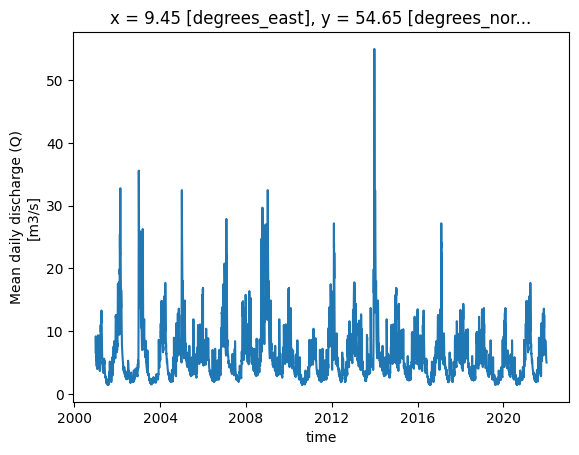

In [34]:
bs[1]["observed"].isel(x=1, y=1).plot()

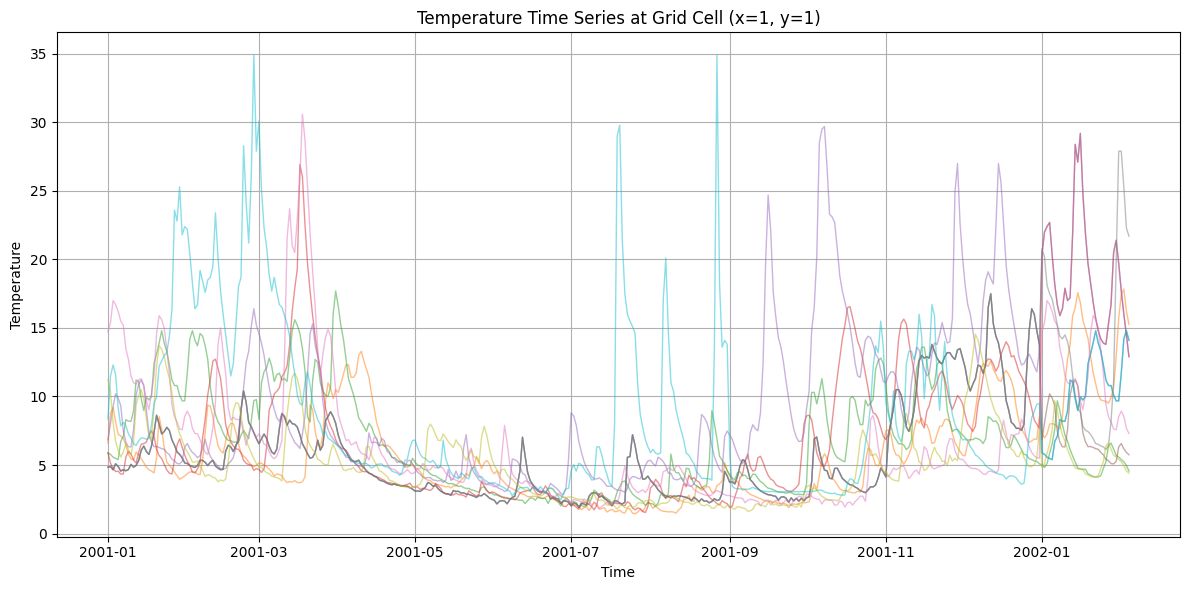

In [37]:
x_idx = 1
y_idx = 1

# Plot temperature for this cell in all bootstrap samples
plt.figure(figsize=(12, 6))
for i, ds in enumerate(bs):
    temp_ts = ds["observed"].isel(x=x_idx, y=y_idx)
    temp_ts = temp_ts[:400]
    plt.plot(temp_ts.time, temp_ts.values, alpha=0.5, label=f"Sample {i}" if i < 10 else "", lw=1)

plt.title(f"Temperature Time Series at Grid Cell (x={x_idx}, y={y_idx})")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
def parallel_ga_wrapper(sample: Dict[str, np.ndarray]) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Wrapper function for parallel GA execution."""
    evaluator = create_evaluator_grid(
        temp=sample['temperature'],
        rad=sample['radiation'],
        prec=sample['precipitation'],
        ndvi=sample['ndvi'],
        observed=sample['observed']
    )
    n_size = 12
    print(sample.dims)
    print("ASDJAKSDHAKFHSfhj")
    return run_ga(
                fitness_func=evaluator,
                genome_length=8*n_size,
                lower_bounds=lowerBounds*n_size,
                upper_bounds=upperBounds*n_size,
                pop_size=100,
                num_generations=20,
                num_parents=40,
                crossover_rate=0.9,
                mutation_rate=0.05,
                mutation_scale=0.2,
                seed=42
            )

def run_parallel_ga_bootstrap(
    dataset: xr.Dataset,
    n_bootstraps: int = 10,
    n_jobs: int = -1
) -> Tuple[List[np.ndarray], List[np.ndarray], List[np.ndarray]]:
    """
    Fully parallelized GA with bootstrap.
    
    Args:
        dataset: xarray Dataset
        n_bootstraps: Number of bootstrap samples
        ga_kwargs: GA configuration
        n_jobs: Number of parallel jobs (-1 for all cores)
        
    Returns:
        (all_best, all_best_hist, all_avg_hist)
    """
   
    # Generate bootstrap samples
    trainVal, test = split_data(dataset, 0.8)
    bootstrap_samples = parallel_year_bootstrap(trainVal, n_samples=n_bootstraps, n_jobs=n_jobs)
    
    # Run GA in parallel
    results = Parallel(n_jobs=n_jobs)(
        delayed(parallel_ga_wrapper)(sample) 
        for sample in tqdm(bootstrap_samples, desc="GA Optimization"))
    
    # Unpack results
    all_best = [r[0] for r in results]
    all_best_hist = [r[1] for r in results]
    all_avg_hist = [r[2] for r in results]
    
    return all_best, all_best_hist, all_avg_hist

In [ ]:
start_time = time.time()
results = run_parallel_ga_bootstrap(
    dataset=data,  # Your xarray Dataset
    n_bootstraps=1
)
duration = time.time() - start_time
print(f"calculations completed in {duration:.5f} seconds.")

GA Optimization: 100%|██████████| 1/1 [00:00<00:00, 972.25it/s]


{'whiskers': [<matplotlib.lines.Line2D at 0x22f98b800b0>,
 'caps': [<matplotlib.lines.Line2D at 0x22f98bd2750>,
 'boxes': [<matplotlib.lines.Line2D at 0x22f9a6848c0>],
 'medians': [<matplotlib.lines.Line2D at 0x22f98dab710>],
 'fliers': [<matplotlib.lines.Line2D at 0x22f98daa690>],
 'means': []}

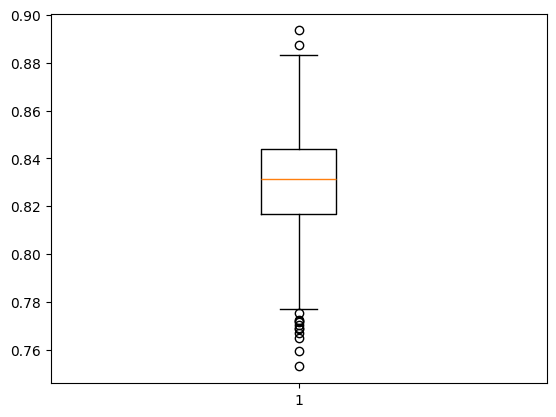

In [40]:
plt.boxplot([r[-1] for r in results[2]])

## Process for all Catchments

In [41]:
data_path = r"data/catchments/GRDC-Daily.nc"
runoff = xr.open_mfdataset(data_path).load()
runoff = runoff.sel(time=slice('2000-03-01', '2022-12-19'))

def load_all_catchment_data(runoff, base_folder="data/catchment_timeseries"):
    all_data = {}

    for folder_name in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder_name)
        if not os.path.isdir(folder_path):
            continue

        # Match station name case-insensitively
        station_ids = runoff["station_name"].values
        match_index = [i for i, name in enumerate(station_ids) if name.lower() == folder_name.lower()]
        
        if not match_index:
            print(f"⚠️  No matching station found for folder: {folder_name}")
            continue

        station_index = match_index[0]

        try:
            temperature = xr.open_mfdataset(os.path.join(folder_path, 'temperature.nc'), combine='by_coords').load()
            precipitation = xr.open_mfdataset(os.path.join(folder_path, 'precipitation.nc'), combine='by_coords').load()
            radiation = xr.open_mfdataset(os.path.join(folder_path, 'radiation.nc'), combine='by_coords').load()
            ndvi = xr.open_mfdataset(os.path.join(folder_path, 'ndvi.nc'), combine='by_coords').load()

            runoff_ts = runoff["runoff_mean"].isel(id=station_index)

            ds = xr.Dataset()
            ds['temperature'] = temperature['t2m']
            ds['precipitation'] = precipitation['precipitation']
            ds['radiation'] = radiation['nr']
            ds['ndvi'] = ndvi['ndvi']
            ds['observed'] = runoff_ts.broadcast_like(ds['radiation'])

            # Clip time
            ds = ds.sel(time=slice('2000-03-01', '2022-12-19'))

            all_data[folder_name] = ds

        except Exception as e:
            print(f"❌ Error loading data for {folder_name}: {e}")

    return all_data

allData = load_all_catchment_data(runoff)

In [43]:
allParams = {}
allRs = {}
start_time = time.time()
for catchment, data in allData.items():
    print(catchment)
    trainVal, test = split_data(data, 0.8)
    results = run_parallel_ga_bootstrap(
    dataset=trainVal,  # Your xarray Dataset
    n_bootstraps=200
        )
        # To analyze results
    all_best = results[0]
    allParams[catchment] = all_best
    allRs[catchment] = results[2]
duration = time.time() - start_time
print(f"calculations completed in {duration:.5f} seconds.")

ACHSTETTEN


Bootstrapping:   0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 